In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.metrics import pairwise_distances
from scanpy import read_h5ad
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

#distribution of distances between 2 types instead of just observation frequency
cell_h5ad = read_h5ad('/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/resegmented_data_copies/all_reseg_with_layers_011023_annotated_with_depth.h5ad')
#obs has class, obsm spatial has location. IDs are matched (so spatial 0 = obs 0)
cell_data = cell_h5ad.obs[cell_h5ad.obs['selected_cells']==True]

## Match Zhuang lab plot 3b in 3 steps
- calculate pairwise distances for pairs of cell subclasses for actual and shuffled data, saving output to a file for each iteration to reduce memory use and need to repeat runs.
- calculate z score of observation frequency between real and shuffled data - are these cells actually proximal or by chance?
- create scatter plot showing z score of observation frequency calculation to match Zhuang 3b plot

In [189]:
import sys
import random
def pairwise_dist_iters(input_df):
    """Iterate over pairs, then over circle point multipliers to get all possible pairwise distance groupings.
    Save to a separate file each time
    """
    obs_freqs = []
    for class_pair in unique_subset_pairs:
        #for each pair of subclasses in all possible pairs of subclasses, skip if we've seen it before (i.e., don't run x vs y if we've run y vs x).
        #additionally, itertools.combinations doesn't return x vs x or y vs y so add those to the potential iteration options if they haven't been done before.
        pair_iters = [[class_pair[0], class_pair[1]]]
        if class_pair[0] not in obs_freqs:
            pair_iters.append([class_pair[0], class_pair[0]])
            obs_freqs.append(class_pair[0])
        if class_pair[1] not in obs_freqs:
            pair_iters.append([class_pair[1], class_pair[1]])
            obs_freqs.append(class_pair[1])
        for group in pair_iters:
            print(group)
            #create blank df for holding the one calculation of true distances and 10 calculations of randomly shifted distances
            temp_df = pd.DataFrame()
            group_name = str(group[0])+','+str(group[1])
            for i in range(0,11): #11
                if i == 0:
                    pair_0 = input_df[input_df['subclass_scANVI']==group[0]][['napari_x', 'napari_y']].values.copy()
                    pair_1 = input_df[input_df['subclass_scANVI']==group[1]][['napari_x', 'napari_y']].values.copy() 
                    if group[0] == group[1]:
                        random.shuffle(pair_1)
                    index = '_realdata'
                else:
                    # uniformly random values within 50um circle
                    n = max(len(input_df[input_df['subclass_scANVI']==group[0]]), len(input_df[input_df['subclass_scANVI']==group[1]]))
                    radius = np.random.uniform(low=0, high=50, size=n*5)  # varies within 50
                    theta = np.random.uniform(low=0, high=2*np.pi, size=n*5)  # angle
                    rand_circle_points = pd.DataFrame({'x': np.sqrt(radius) * np.cos(theta), 'y':np.sqrt(radius) * np.sin(theta)}) #circle
                    rand_subset_0 = rand_circle_points.sample(len(input_df[input_df['subclass_scANVI']==group[0]])).values.copy()
                    rand_subset_1 = rand_circle_points.sample(len(input_df[input_df['subclass_scANVI']==group[1]])).values.copy()
                    pair_0 = input_df[input_df['subclass_scANVI']==group[0]][['napari_x', 'napari_y']].values.copy()+rand_subset_0
                    if group[0]==group[1]:
                        pair_1 = pair_0
                    else:
                        pair_1 = input_df[input_df['subclass_scANVI']==group[1]][['napari_x', 'napari_y']].values.copy()+rand_subset_1
                    index = '_iter'+str(i)
                clust_dists_pair = np.tril(pairwise_distances(pair_0, pair_1, n_jobs=1)) 
                clust_dists_pair[clust_dists_pair==0] = np.nan
                pair_col = group_name+index
                pair_df = pd.DataFrame(pd.Series(clust_dists_pair.flatten()[:]), columns = [pair_col])
                temp_df = pd.concat([temp_df, pair_df], axis=1) 
            if '/' in group_name:
                group_name = group_name.replace('/', '')
            csv_name = str(root_folder.joinpath(barcode))+'/'+barcode+'_'+group_name+'_10423.csv'
            temp_df.to_csv(csv_name, index=False)

In [191]:
def calc_z_score(new_root, bc):
    cci_csvs = new_root.glob('*.csv')
    obs_freqs = pd.DataFrame(columns=['pair_0', 'pair_1', 'z_score'])
    for cci in list(cci_csvs):
        # calculate one-tailed z-test of observed vs randomized for every group
        group_df = pd.read_csv(cci)
        slim_df = group_df[group_df.transform(lambda x: x <= 15)].dropna(how='all')
        sample_colname = [x for x in list(slim_df.columns) if '_realdata' in x][0]
        sample = slim_df.loc[:, slim_df.columns == sample_colname].count()
        population = slim_df.loc[:, slim_df.columns != sample_colname].count()
        # z = (sample mean – population mean) / [population standard deviation/sqrt(n)]
        z = (sample - np.mean(population)) / (np.std(population)/np.sqrt(10)) 
        comp_vals = sample_colname.split(',')
        obs_freqs.loc[len(obs_freqs), obs_freqs.columns] = comp_vals[0], comp_vals[1].split('_')[0], z.values[0]
        if abs(z.values[0]) >= 0.5:
            split_name = cci.stem.split('_')
            bc = split_name[0]
            comp_classes = split_name[1]
            z_df = group_df[group_df.transform(lambda x: x <= 100)].dropna(how='all')
            plt.figure()
            real_hist = plt.hist(z_df.loc[:, z_df.columns == sample_colname], color = 'y', alpha=0.5, bins = 10, range = (0, 110), label = 'real data')
            try:
                shuf_hist = plt.hist(z_df.loc[:, z_df.columns != sample_colname].iloc[:, 1], alpha=0.5, bins = 10, range = (0, 110), label = 'shuffled data')
            except ValueError:
                continue
            plt.xlabel(sample_colname.split('_')[0])
            plt.ylabel('counts')
            plt.title(comp_classes + ' '+ bc)
            plt.text(80, 2, 'z score: '+str(round(z.values[0], 3)))
            plt.legend()
            #print(str(new_root.joinpath(bc+'_'+comp_classes+'_100um_hist.png')))
            plt.savefig(str(new_root.joinpath(bc+'_'+comp_classes+'_100um_hist.png')))
    return obs_freqs

In [4]:
def cci_bubble_plot(unique_classes, obs_freqs, savepath, bc):
    #put everything together - pairs and inverses, coordinates for plotting, and proximity values for adjusting size/color of plotted point
    for i in range(len(unique_classes)):
        for j in range(len(unique_classes)):
            idx = obs_freqs.index[(obs_freqs['pair_0']==unique_classes[i])&(obs_freqs['pair_1']==unique_classes[j])]
            obs_freqs.loc[idx, 'x'] = i
            obs_freqs.loc[idx, 'y'] = j

    #create scatterplot of the above matrix that matches the Zhuang 3B plot
    class_to_color = {'exc': 'red', 'inh': 'blue', 'glia': 'k'}
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.scatter(obs_freqs['x'], obs_freqs['y'], s=obs_freqs['z_score'].tolist(), c = obs_freqs['z_score'].tolist(), vmin = -50, vmax=50)
    plt.scatter(obs_freqs['y'], obs_freqs['x'], s=obs_freqs['z_score'].tolist(), c = obs_freqs['z_score'].tolist(), vmin = -50, vmax=50)


    plt.xticks(range(len(unique_classes)), unique_classes, size='small', rotation=70)
    for xtic in ax.get_xticklabels():
        xtic.set_color(class_to_color[subclass_to_class[xtic.get_text()]])

    plt.yticks(range(len(unique_classes)), unique_classes, size='small')
    for ytic in ax.get_yticklabels():
        ytic.set_color(class_to_color[subclass_to_class[ytic.get_text()]])

    plt.title(bc+' abs(z)>=0.5')
    plt.colorbar()
    plt.savefig(savepath)

## Run the above functions with real data
- convert from loop to single barcode as needed

['Astro', 'Chandelier']
['Astro', 'Astro']
['Chandelier', 'Chandelier']
['Astro', 'Endo']
['Endo', 'Endo']
['Astro', 'L2/3 IT']
['L2/3 IT', 'L2/3 IT']
['Astro', 'L4 IT']
['L4 IT', 'L4 IT']
['Astro', 'L5 ET']
['L5 ET', 'L5 ET']
['Astro', 'L5 IT']
['L5 IT', 'L5 IT']
['Astro', 'L5/6 NP']
['L5/6 NP', 'L5/6 NP']
['Astro', 'L6 CT']
['L6 CT', 'L6 CT']
['Astro', 'L6 IT']
['L6 IT', 'L6 IT']
['Astro', 'L6 IT Car3']
['L6 IT Car3', 'L6 IT Car3']
['Astro', 'L6b']
['L6b', 'L6b']
['Astro', 'Lamp5']
['Lamp5', 'Lamp5']
['Astro', 'Lamp5_Lhx6']
['Lamp5_Lhx6', 'Lamp5_Lhx6']
['Astro', 'Micro-PVM']
['Micro-PVM', 'Micro-PVM']
['Astro', 'OPC']
['OPC', 'OPC']
['Astro', 'Oligo']
['Oligo', 'Oligo']
['Astro', 'Pax6']
['Pax6', 'Pax6']
['Astro', 'Pvalb']
['Pvalb', 'Pvalb']
['Astro', 'Sncg']
['Sncg', 'Sncg']
['Astro', 'Sst']
['Sst', 'Sst']
['Astro', 'Sst Chodl']
['Sst Chodl', 'Sst Chodl']
['Astro', 'VLMC']
['VLMC', 'VLMC']
['Astro', 'Vip']
['Vip', 'Vip']
['Chandelier', 'Endo']
['Chandelier', 'L2/3 IT']
['Chandelier'

/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_Astro,Sst_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_Endo,L6 CT_100um_hist.png


/home/imaging_mfish/anaconda3/envs/survey_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_Endo,Pvalb_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L4 IT,L6b_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L4 IT,Sst_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L5 IT,Lamp5_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L5 IT,Micro-PVM_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L6 CT,L6b_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L6 IT,Lamp5_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L6 IT,VLMC_100um_hist.png
/hom

/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L4 IT,L6 IT Car3_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L5 IT,Lamp5_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L6 IT,OPC_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L6 IT,Oligo_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_OPC,Vip_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_L5 ET,L5 ET_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_Astro,L5 IT_100um_hist.png
/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/1238559483/1238559483_Astro,L6 IT Car3_100um_hist.

/home/imaging_mfish/anaconda3/envs/survey_analysis/lib/python3.7/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


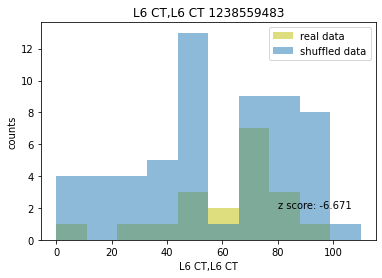

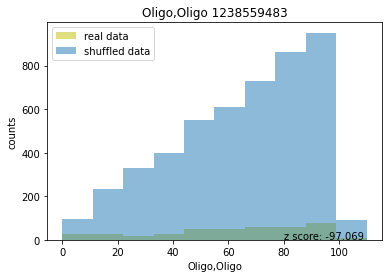

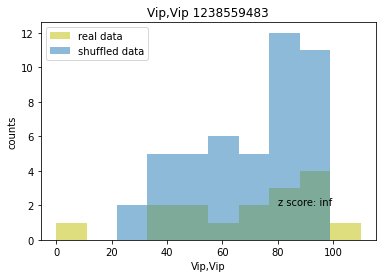

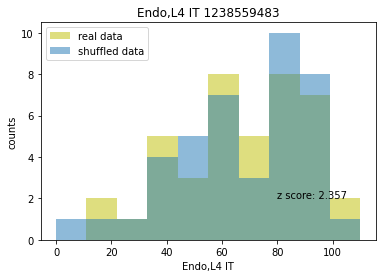

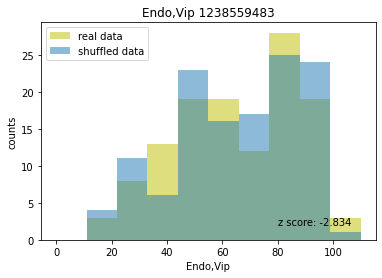

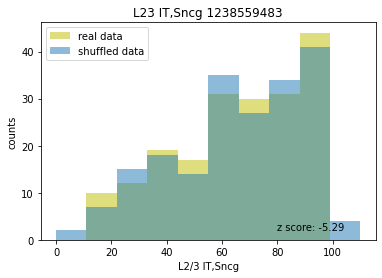

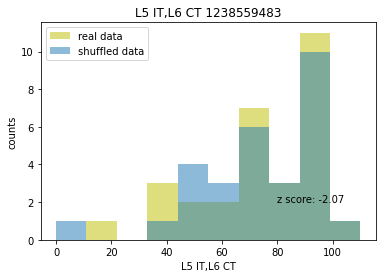

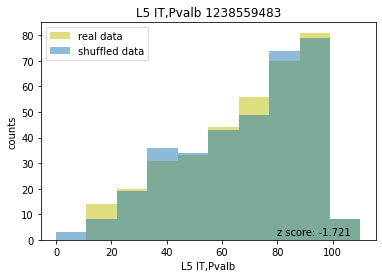

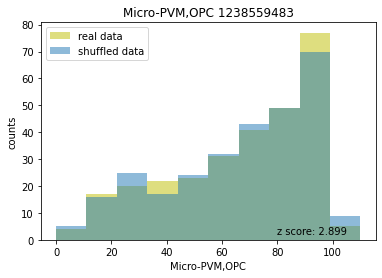

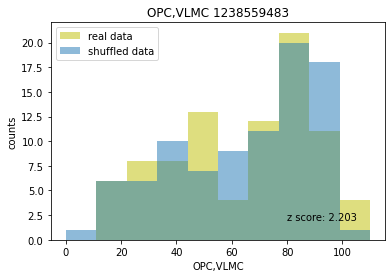

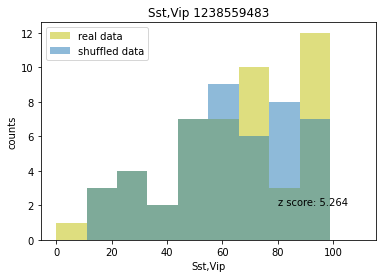

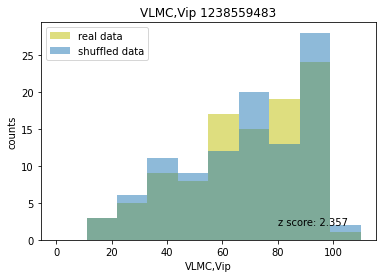

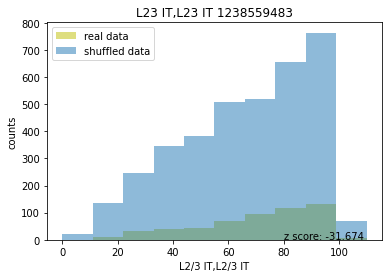

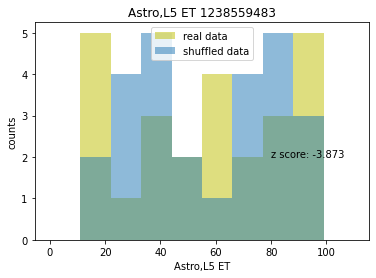

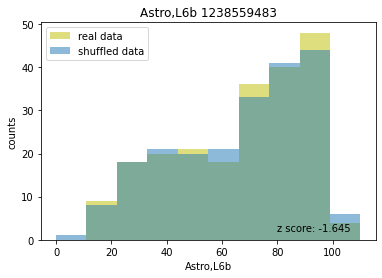

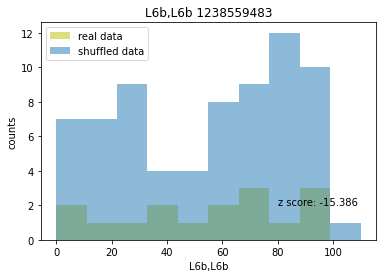

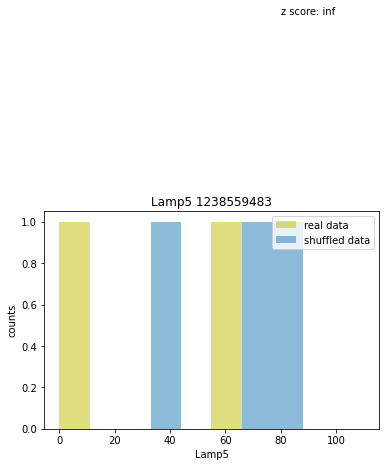

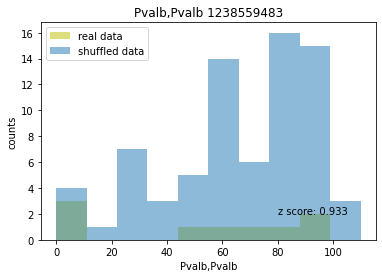

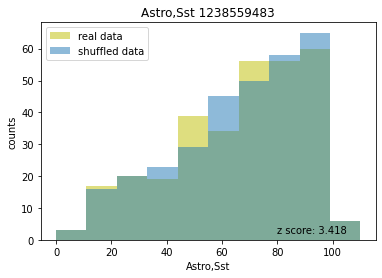

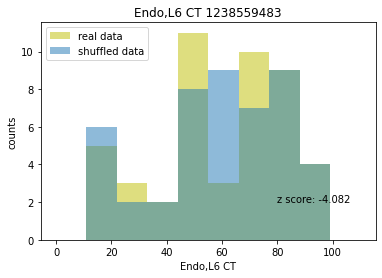

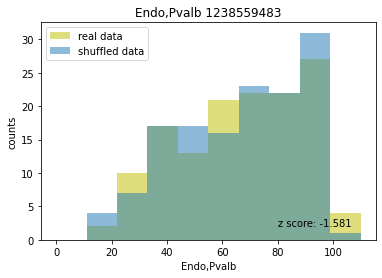

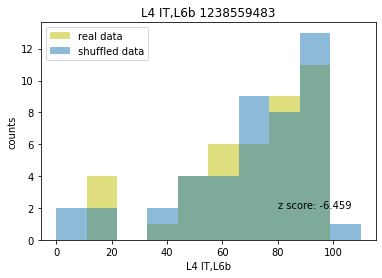

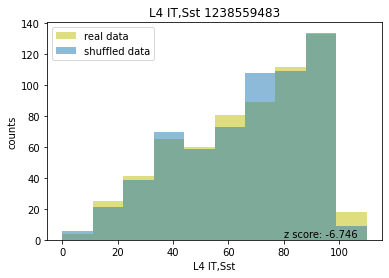

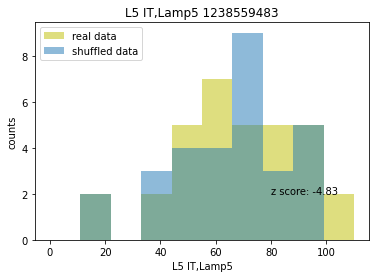

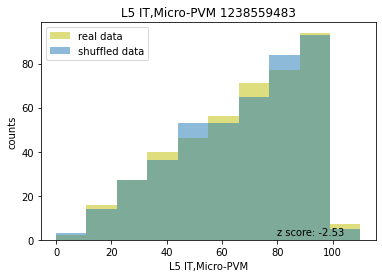

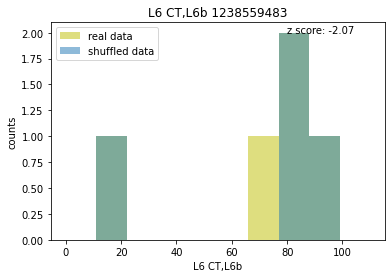

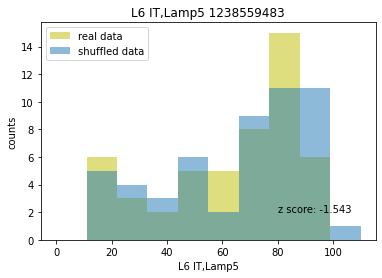

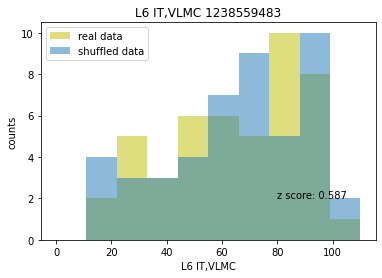

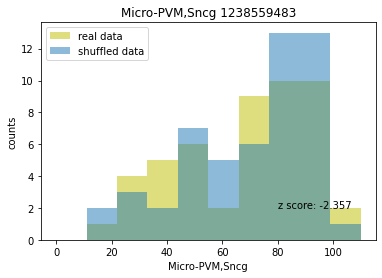

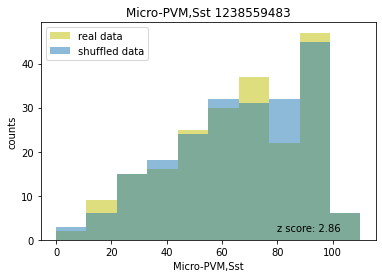

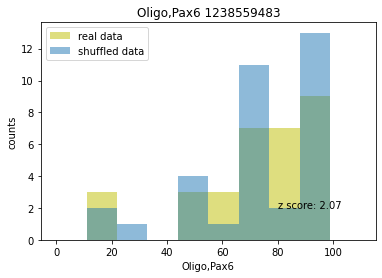

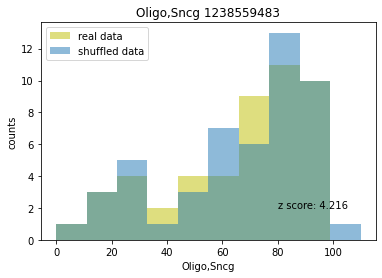

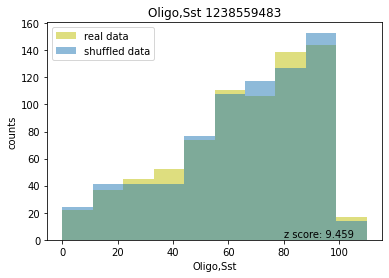

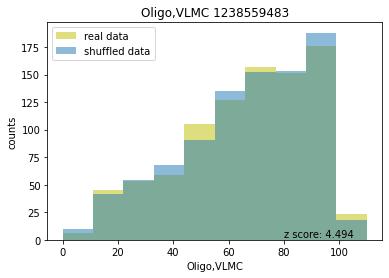

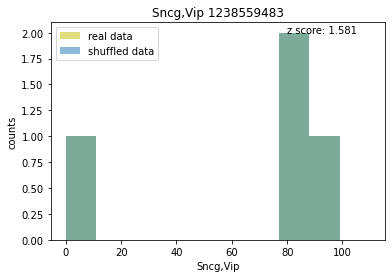

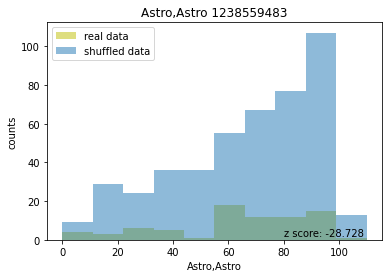

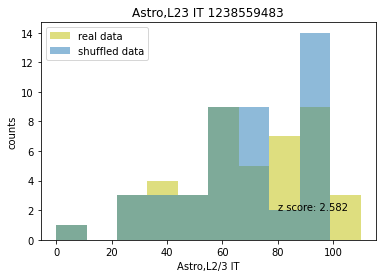

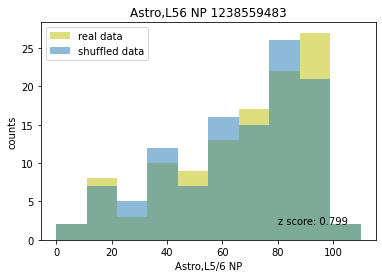

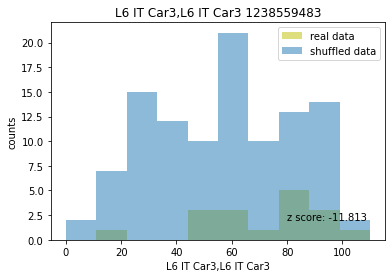

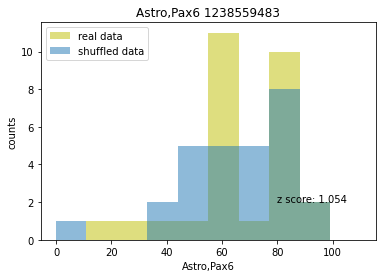

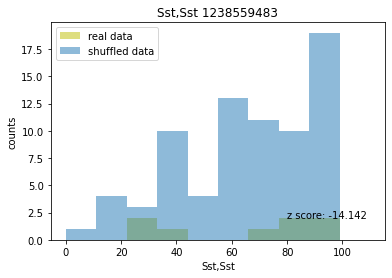

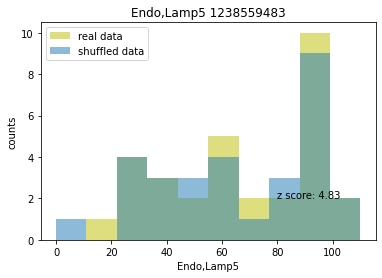

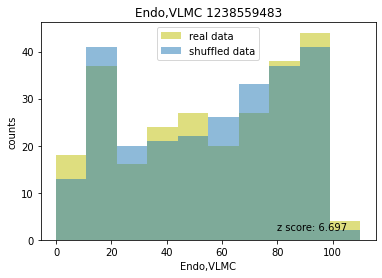

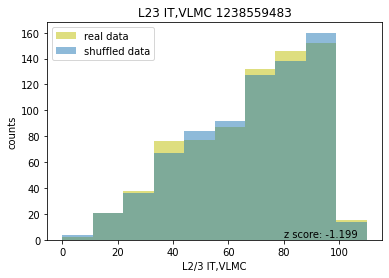

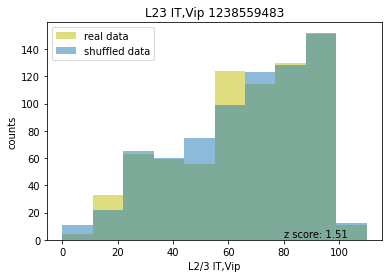

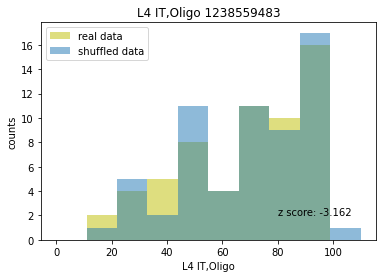

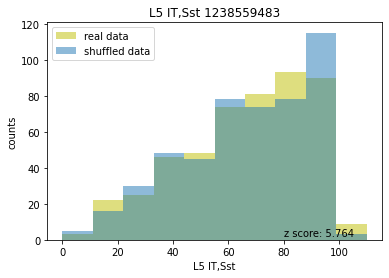

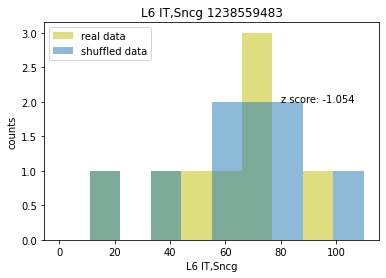

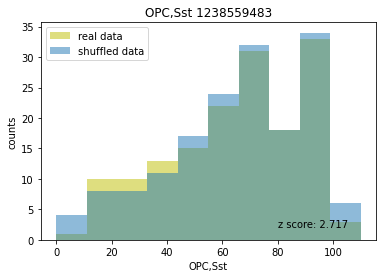

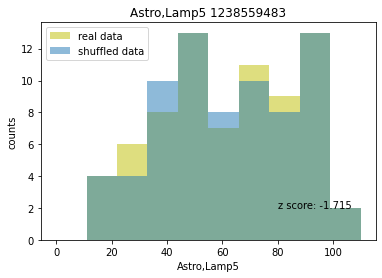

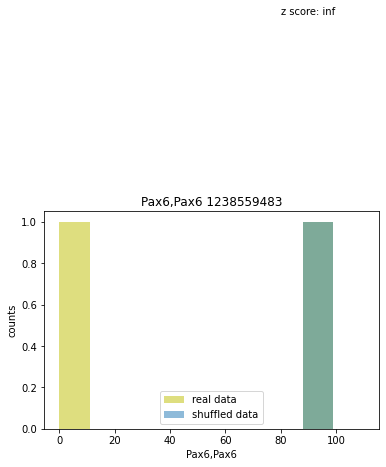

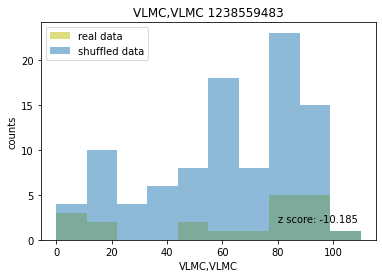

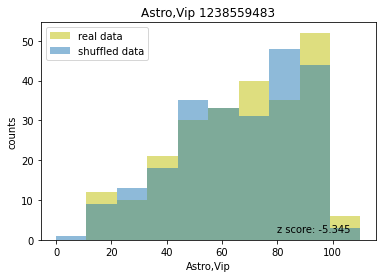

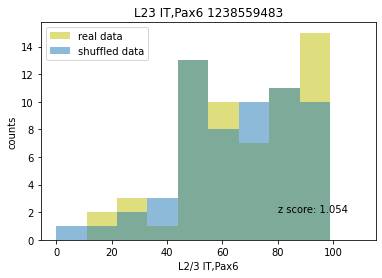

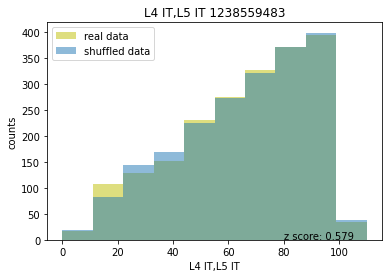

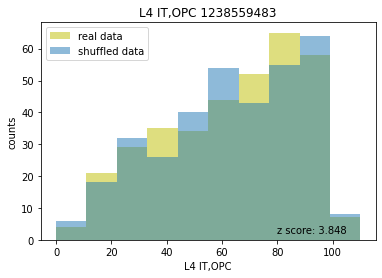

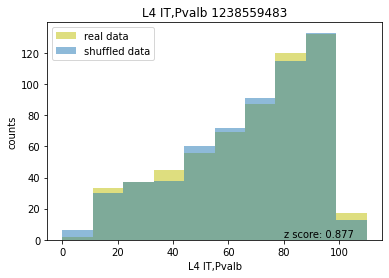

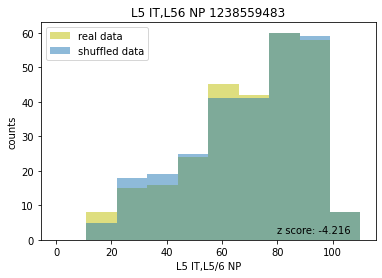

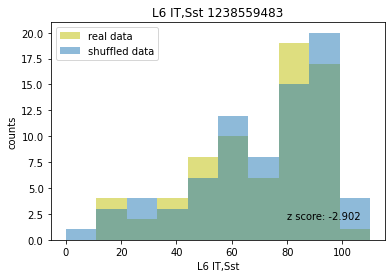

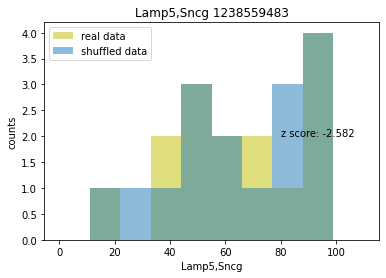

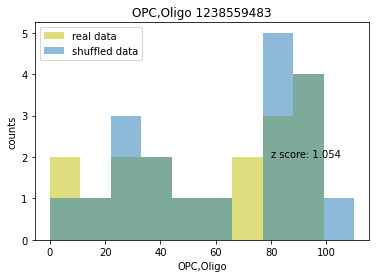

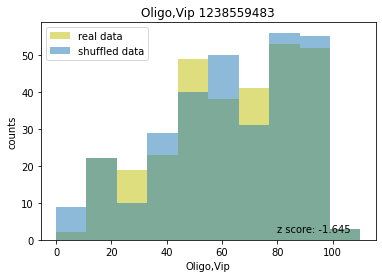

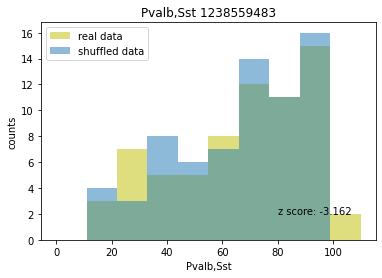

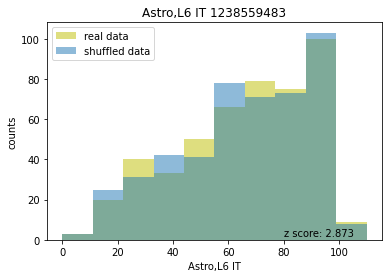

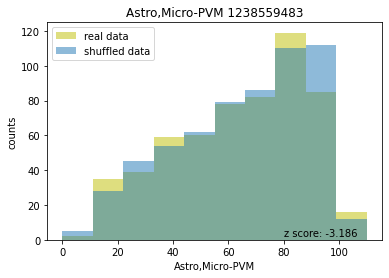

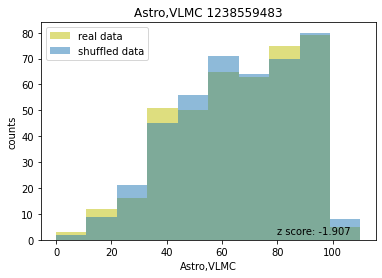

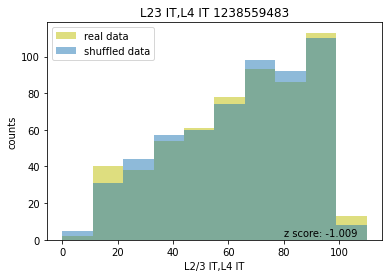

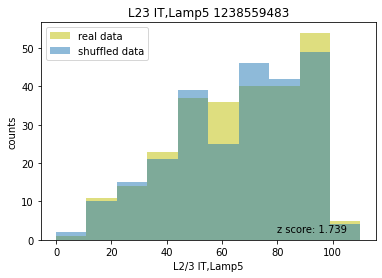

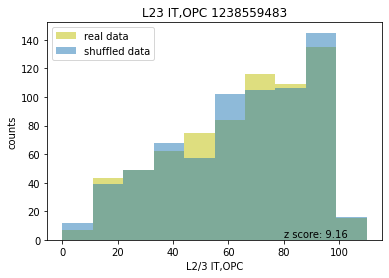

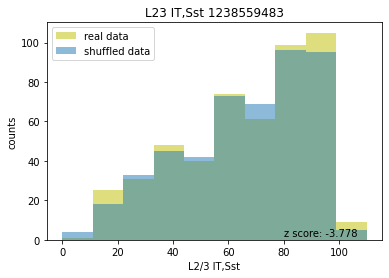

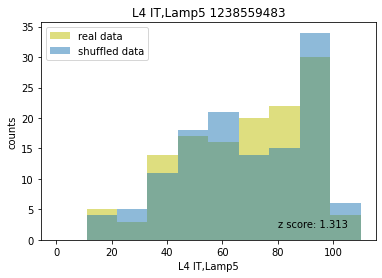

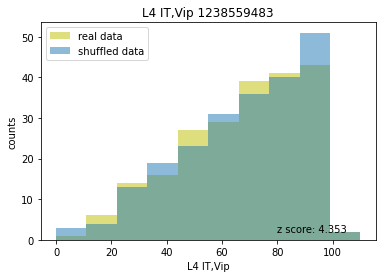

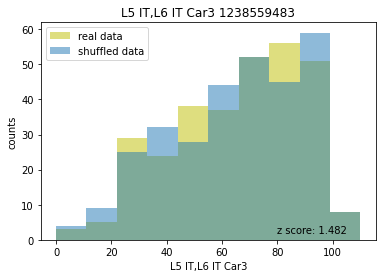

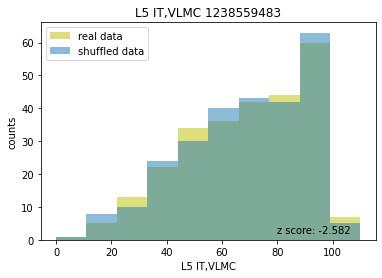

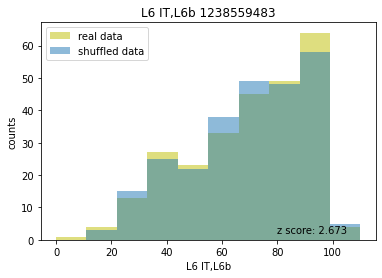

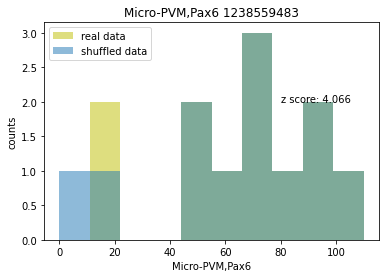

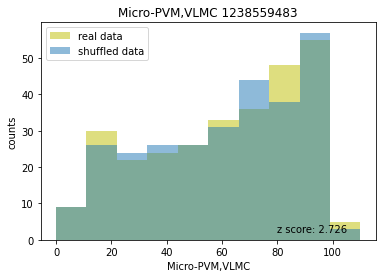

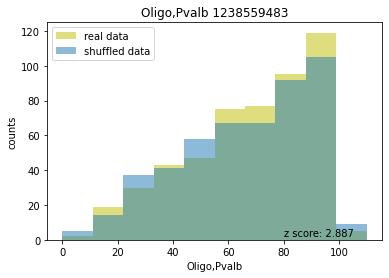

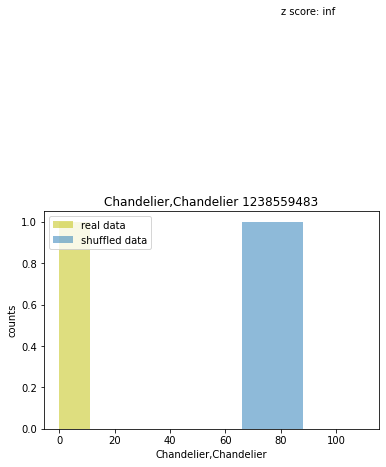

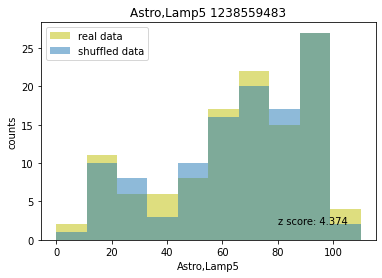

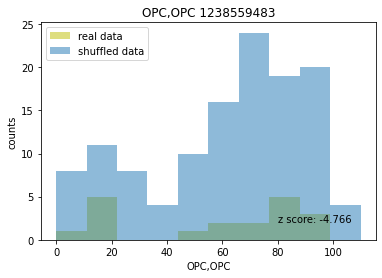

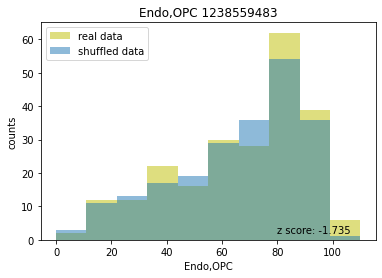

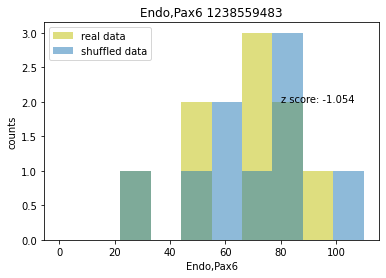

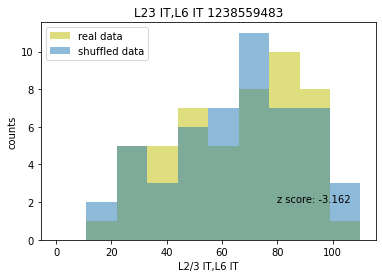

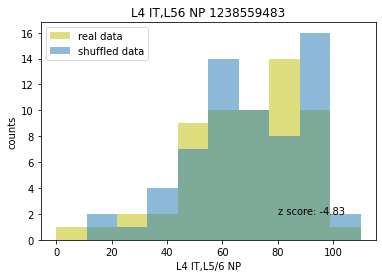

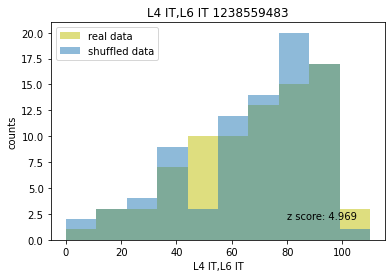

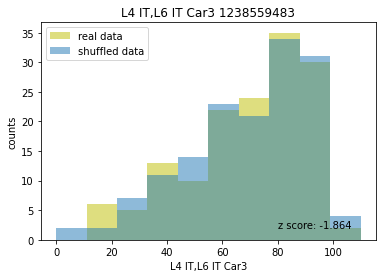

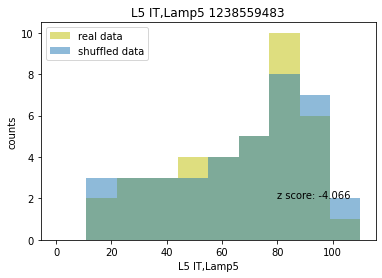

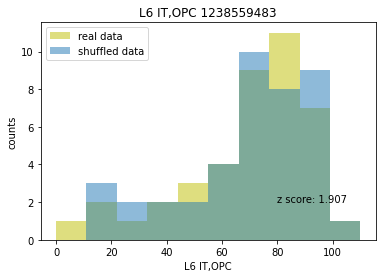

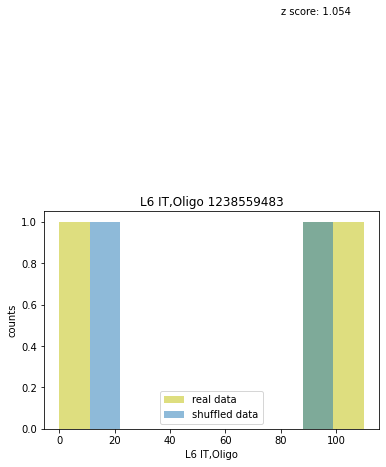

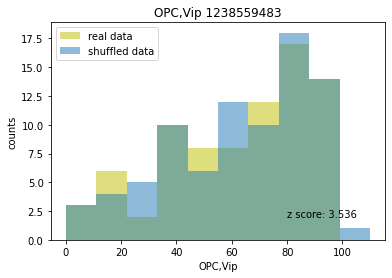

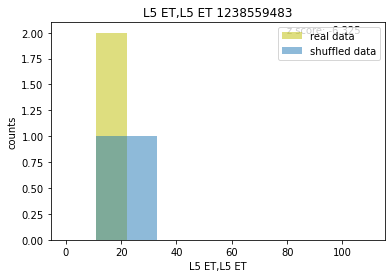

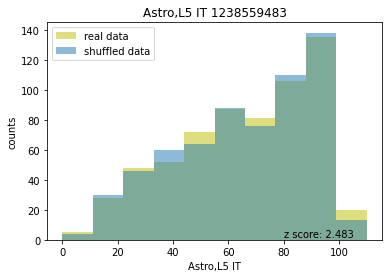

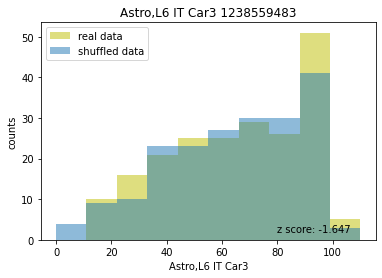

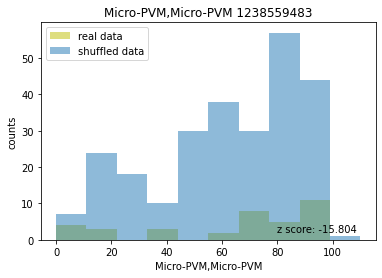

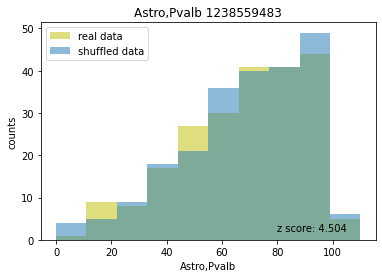

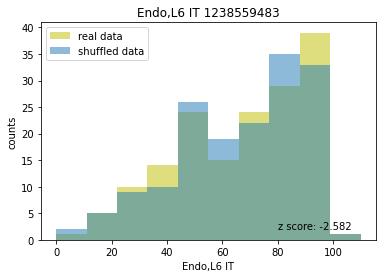

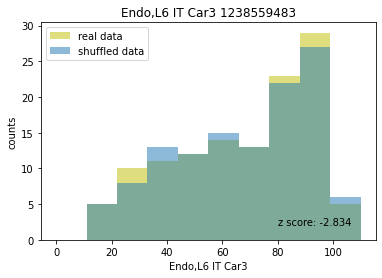

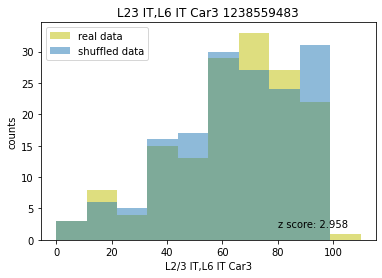

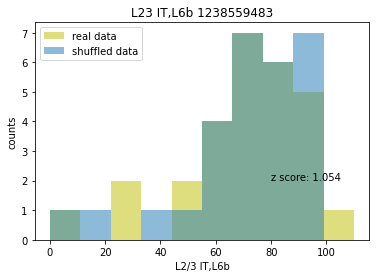

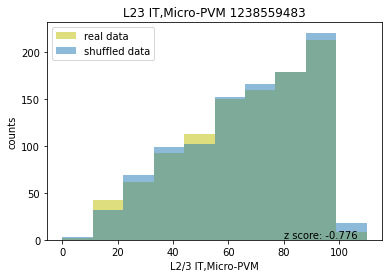

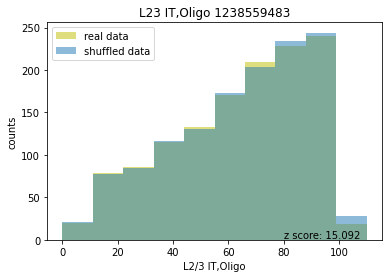

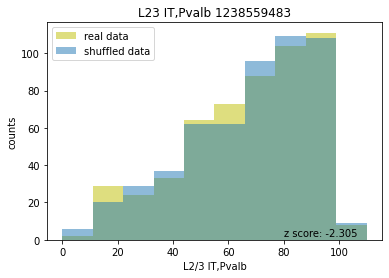

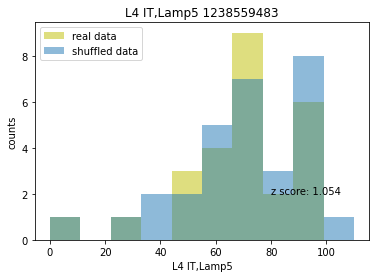

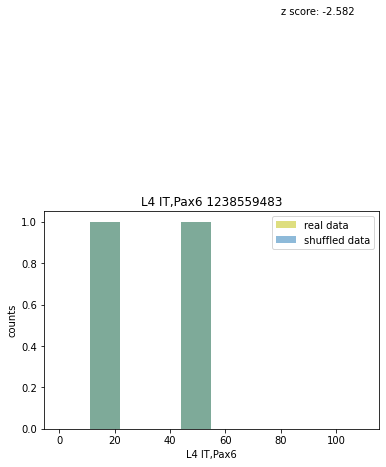

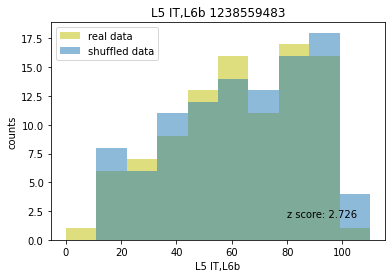

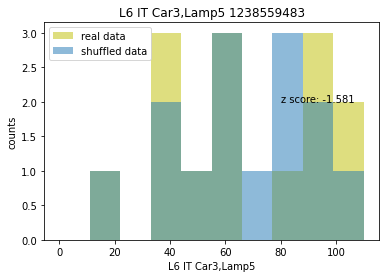

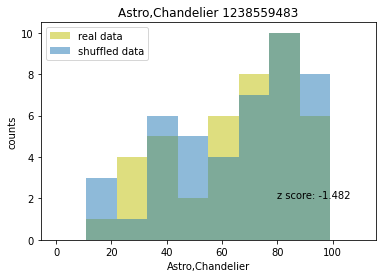

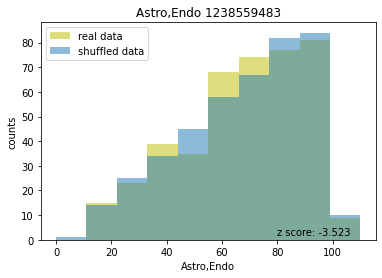

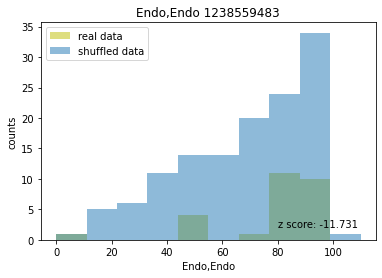

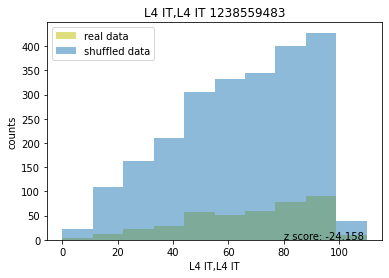

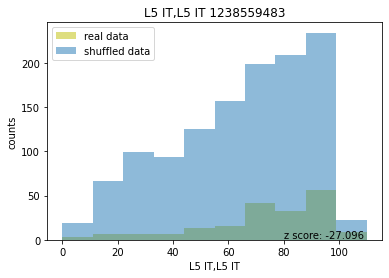

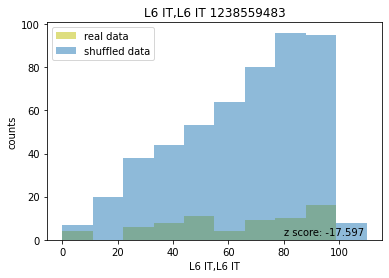

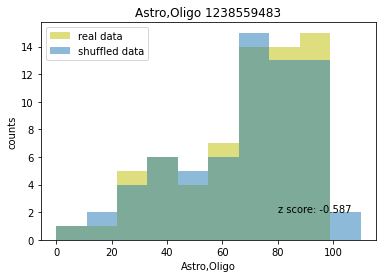

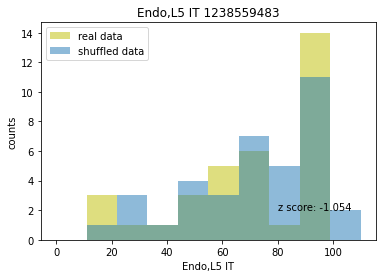

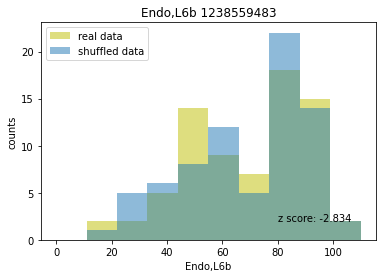

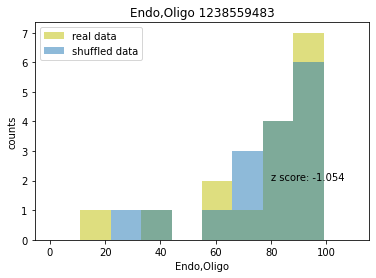

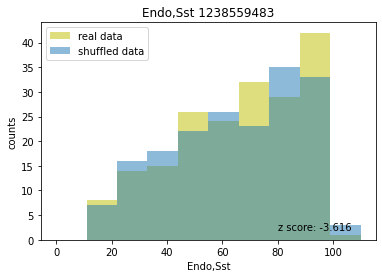

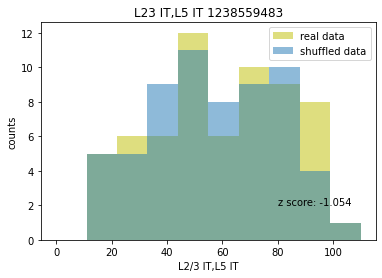

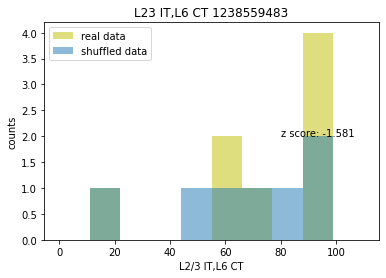

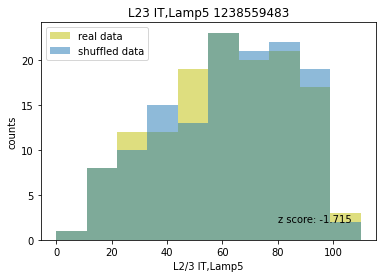

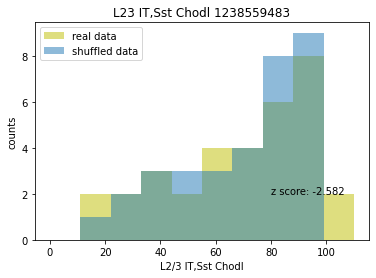

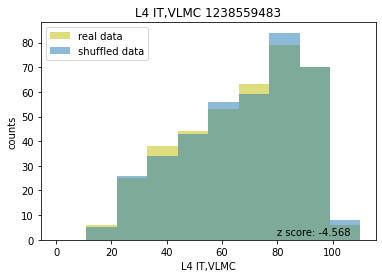

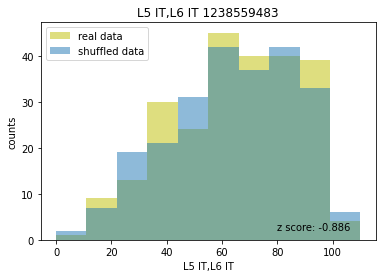

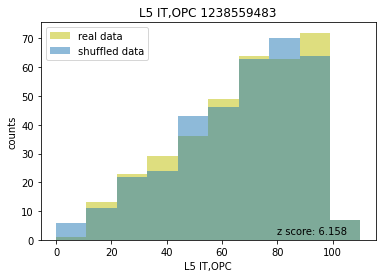

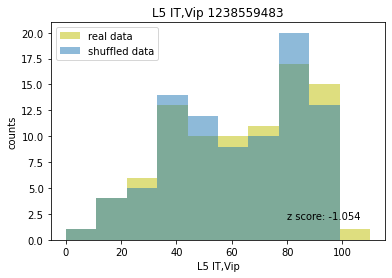

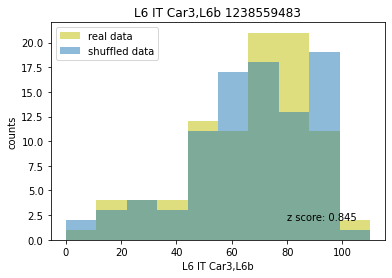

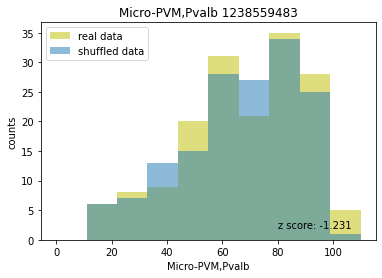

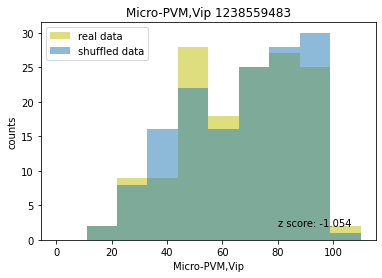

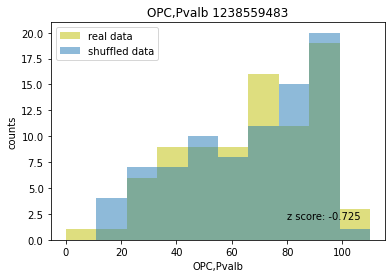

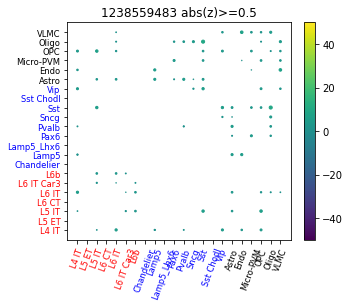

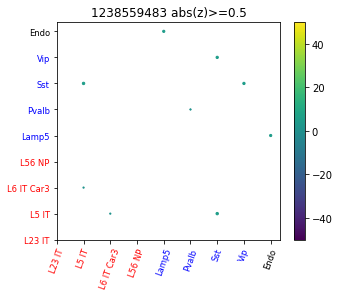

In [190]:
for barcode in cell_data['filename'].unique().tolist():
#barcode = '1238559483'
    subset_data= cell_data[cell_data['filename']==barcode].copy() 
    subclasses = list(subset_data.groupby('subclass_scANVI').groups.keys())
    unique_subset_pairs = list(itertools.combinations(subclasses, 2))
    root_folder = Path('/home/imaging_mfish/surveyNAS05/scratch/human/AD_MTG/results/manuscript_cci/')
    root_folder.joinpath(barcode).mkdir(parents=True, exist_ok=True)
    pairwise_dist_iters(subset_data)
    new_root = root_folder.joinpath(barcode)
    obs_freqs = calc_z_score(new_root, barcode)

    #grab set of all subclasses in list of significant pairs
    flat_split = obs_freqs['pair_1'].unique().tolist() + obs_freqs['pair_0'].unique().tolist()
    u_subc = list(subset_data['subclass_scANVI'].unique())
    classes = [subset_data[subset_data['subclass_scANVI']==sub]['class'].values[0] for sub in u_subc]
    u_subc_noslash=[x.replace('/', '') for x in u_subc]
    subclass_to_class = dict(zip(u_subc_noslash, classes)) 

    #organize to match Zhuang figure
    exc_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='exc' and sub in flat_split])
    inh_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='inh' and sub in flat_split])
    glia_subc = sorted([sub for sub in u_subc_noslash if subclass_to_class[sub]=='glia' and sub in flat_split])
    unique_classes = exc_subc+inh_subc+glia_subc
    cci_bubble_plot(unique_classes, obs_freqs.copy(), new_root.joinpath(barcode+'_3b_fullplot.png'), barcode)

    zhuang_subs = ['L23 IT', 'L5 IT', 'L6 IT Car3','L56 NP','Lamp5', 'Pvalb', 'Sst', 'Vip', 'Endo']
    cci_bubble_plot(zhuang_subs, obs_freqs.copy(), new_root.joinpath(barcode+'_3b_zmatch.png'), barcode)